## Imports

### Install packages.

In [1]:
!sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet jupyterlab-vim)"
!jupyter labextension enable

In [2]:
# TODO(gp): Add this to poetry.
try:
    import preliz as pz
except ModuleNotFoundError:
    !sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet preliz)"
    pass

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Import modules

In [4]:
%load_ext autoreload
%autoreload 2

import logging

import arviz as az
import pymc as pm
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import preliz as pz

In [3]:
import utils

utils.notebook_signature()

Python 3.12.3
Linux 689d1a3566d0 6.12.5-linuxkit #1 SMP Tue Jan 21 10:23:32 UTC 2025 aarch64 aarch64 aarch64 GNU/Linux
numpy version=1.26.4
pymc version=5.18.2
matplotlib version=3.10.0
arviz version=0.20.0
preliz version=0.15.0


### Style notebook.

In [5]:
plt.rcParams['figure.figsize'] = [8, 3]

# Chap1: Thinking probabilistically

## Gaussian

In [6]:
np.random.seed(42)

# Create a Normal Gaussian.
mu = 0.0
sigma = 1.0
X = stats.norm(mu, sigma)

# Print 3 realizations.
x = X.rvs(3)
print(x)

[ 0.49671415 -0.1382643   0.64768854]


Text(0, 0.5, 'p(x)')

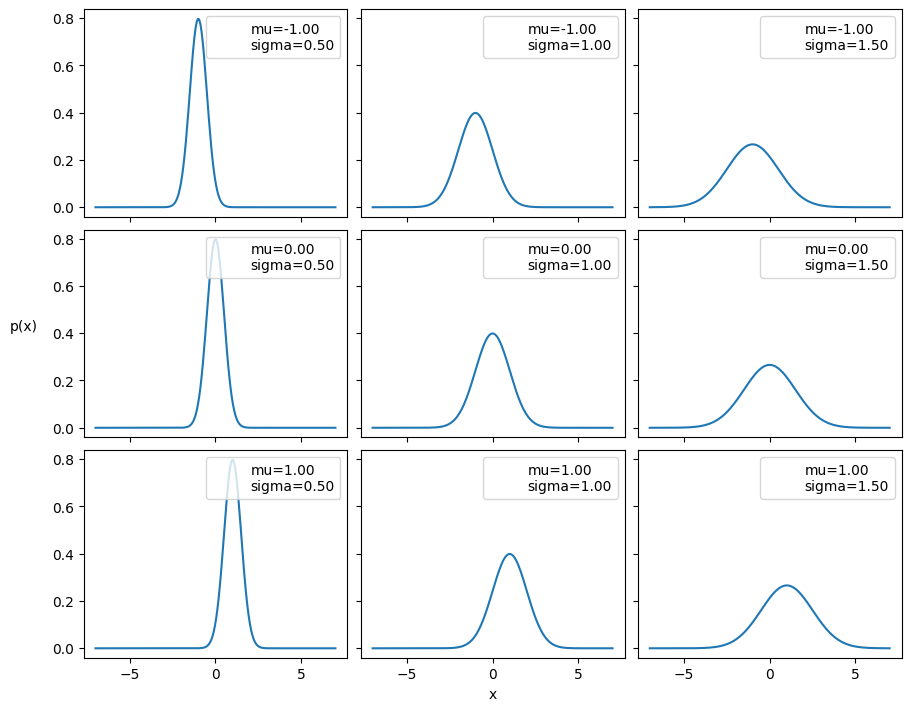

In [7]:
# - Plot Gaussian PDF for different values of the params.

mu_params = [-1, 0, 1]
sd_params = [0.5, 1, 1.5]
x = np.linspace(-7, 7, 200)
# Create a 3x3 plot.
_, ax = plt.subplots(len(mu_params),
                     len(sd_params),
                     sharex=True,
                     sharey=True,
                     figsize=(9, 7),
                     # Fit plots into the figure cleanly.
                     constrained_layout=True)
                     #constrained_layout=False)
for i in range(3):
    for j in range(3):
        mu = mu_params[i]
        sd = sd_params[j]
        # Evaluate the PDF in several points.
        y = stats.norm(mu, sd).pdf(x)
        # Plot the PDF.
        ax[i, j].plot(x, y)
        # Add the legend.
        ax[i, j].plot([], label="mu={:3.2f}\nsigma={:3.2f}".format(mu, sd), alpha=0)
        ax[i, j].legend(loc=1)
ax[2, 1].set_xlabel('x')
ax[1, 0].set_ylabel('p(x)', rotation=0, labelpad=20)
#ax[1, 0].set_yticks([])

In [8]:
params = {
    #"kind": "cdf",
    "kind": "pdf",
    "pointinterval": False,
    "interval": "hdi",   # Highest density interval.
    #"interval": "eti",  # Equal tailed interval.
    "xy_lim": "auto"
}

pz.Normal(mu=0, sigma=1).plot_interactive(**params)

interactive(children=(FloatSlider(value=0.0, description='mu (-inf, inf)', max=10.0, min=-10.0, style=SliderSt…

In [9]:
# Generate some samples.
pdf = pz.Normal(mu=0, sigma=1)
pdf.rvs(10)

array([-0.00687092, -0.37034326,  0.24969365,  0.16873088, -0.90781269,
        0.00840432, -0.66011988,  0.56967911,  1.02072406,  0.00626343])

In [12]:
#?plt.hist

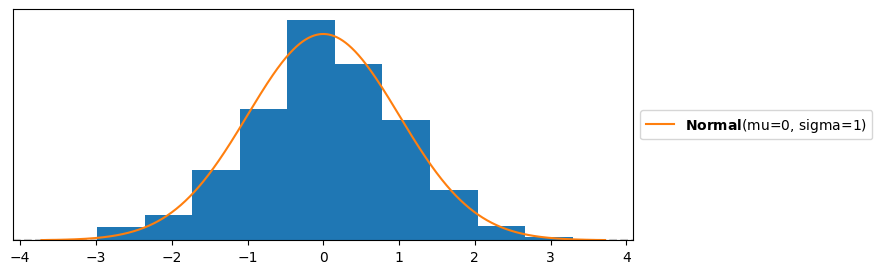

In [13]:
#n = 100
#n = 1000
n = 100_000_000
plt.hist(pdf.rvs(1000), density=True)
pdf.plot_pdf();

## Binomial

In [14]:
help(pz.Binomial.plot_interactive)

Help on function plot_interactive in module preliz.distributions.distributions:

plot_interactive(self, kind='pdf', xy_lim='both', pointinterval=True, interval=None, levels=None, figsize=None)
    Interactive exploration of distributions parameters

    Parameters
    ----------
    kind : str:
        Type of plot. Available options are `pdf`, `cdf` and `ppf`.
    xy_lim : str or tuple
        Set the limits of the x-axis and/or y-axis.
        Defaults to `"both"`, the limits of both axis are fixed.
        Use `"auto"` for automatic rescaling of x-axis and y-axis.
        Or set them manually by passing a tuple of 4 elements,
        the first two for x-axis, the last two for y-axis. The tuple can have `None`.
    pointinterval : bool
        Whether to include a plot of the quantiles. Defaults to False. If True the default is to
        plot the median and two interquantiles ranges.
    interval : str
        Type of interval. Available options are highest density interval `"hdi"` 

In [15]:
params = {
    #"kind": "cdf",
    "kind": "pdf",
    "pointinterval": False,
    "interval": "hdi",   # Highest density interval.
    #"interval": "eti",  # Equal tailed interval.
    "xy_lim": "auto"
}

# Probability of k successes on N trial flipping a coin with p success
pz.Binomial(p=0.5, n=5).plot_interactive(**params)

interactive(children=(IntSlider(value=5, description='n (0, inf)', max=15, style=SliderStyle(description_width…

## Beta

- Continuous prob distribution defined in [0, 1]
- It is useful to model probability or proportion
    - E.g., the probability of success in a Bernoulli trial

- alpha represents "success" parameter
- beta represents "failure" parameter
    - When alpha is larger than beta the distribution skews toward 1, indicating a higher probability of success
    - When alpha = beta the distribution is symmetric and centered around 0.5

In [16]:
params = {
    #"kind": "cdf",
    "kind": "pdf",
    "pointinterval": False,
    "interval": "hdi",   # Highest density interval.
    #"interval": "eti",  # Equal tailed interval.
    "xy_lim": "auto"
}

alpha = 3.0
beta = 1.0

pz.Beta(alpha=alpha, beta=beta).plot_interactive(**params)

interactive(children=(FloatSlider(value=3.0, description='alpha (0, inf)', max=13.0, min=2.220446049250313e-16…

In [17]:
np.random.seed(123)

trials = 4
# Unknown value.
theta_real = 0.35

# Generate some values.
data = stats.bernoulli.rvs(p=theta_real, size=trials)
print(data)

[1 0 0 0]


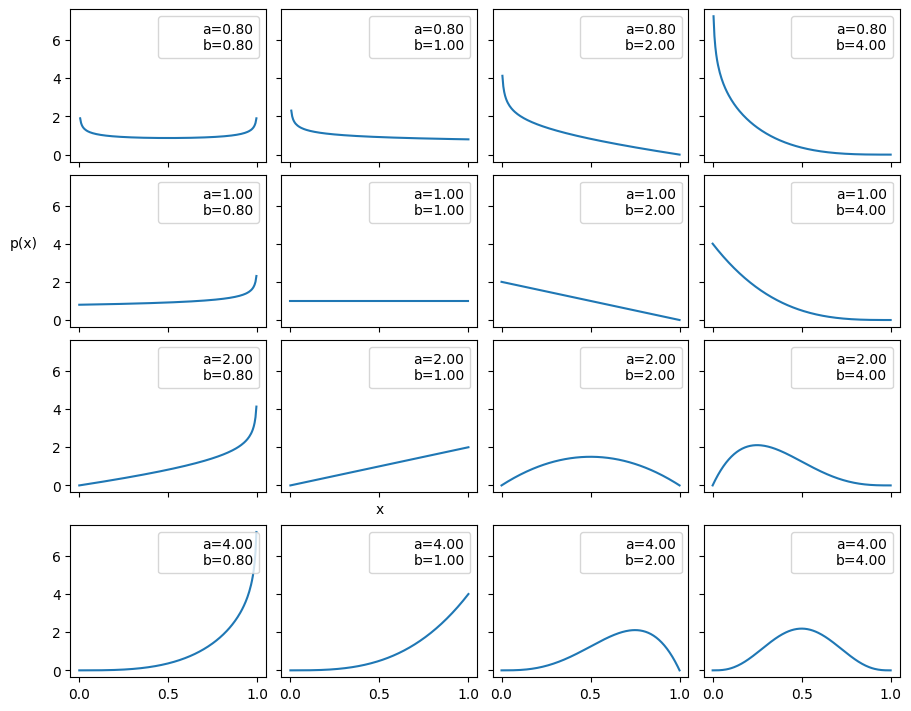

In [18]:
params1 = [0.8, 1.0, 2.0, 4.0]
params2 = [0.8, 1.0, 2.0, 4.0]
x = np.linspace(0, 1, 200)
# Create a plot.
_, ax = plt.subplots(len(params1),
                     len(params2),
                     sharex=True,
                     sharey=True,
                     figsize=(9, 7),
                     # Fit plots into the figure cleanly.
                     constrained_layout=True)
                     #constrained_layout=False)
for i in range(len(params1)):
    for j in range(len(params2)):
        param1 = params1[i]
        param2 = params2[j]
        # Evaluate the PDF in several points.
        y = stats.beta(a=param1, b=param2).pdf(x)
        # Plot the PDF.
        ax[i, j].plot(x, y)
        # Add the legend.
        ax[i, j].plot([], label="a={:3.2f}\nb={:3.2f}".format(param1, param2), alpha=0)
        ax[i, j].legend(loc=1)
ax[2, 1].set_xlabel('x')
ax[1, 0].set_ylabel('p(x)', rotation=0, labelpad=20);
#ax[1, 0].set_yticks([])

### Beta in function of mean and concentration.

In [19]:
#help(stats.beta)

In [20]:
params = {
    #"kind": "cdf",
    "kind": "pdf",
    "pointinterval": False,
    "interval": "hdi",   # Highest density interval.
    #"interval": "eti",  # Equal tailed interval.
    "xy_lim": "auto"
}

mu = 1.0
nu = 0.1
alpha = mu * nu
beta = (1.0 - mu) * nu
print(alpha, beta)

# x = np.linspace(0, 1, 200)
# y = stats.beta(a=alpha, b=beta).pdf(x)
# # Plot the PDF.
# plt.plot(x, y);

pz.Beta(mu=0.5, nu=0.5).plot_interactive(**params)

0.1 0.0


interactive(children=(FloatSlider(value=0.5, description='mu (0, 1)', max=0.9999999999999998, min=2.2204460492…

## BetaBinomial

- Discrete RV
- Represent the probability of success in a series of Bernoulli trials
- The Binomial models the number of successes in a fixed number of trials $n$
- The probability of success $p$ is not fixed but follows a Beta distribution

In [21]:
pz.BetaBinomial(alpha=10, beta=10, n=6).plot_interactive()

interactive(children=(FloatSlider(value=10.0, description='alpha (0, inf)', max=110.0, min=2.220446049250313e-…

In [22]:
# Generate some samples.
pz.BetaBinomial(alpha=10, beta=10, n=60).rvs(100)

array([24, 27, 34, 30, 24, 30, 33, 26, 30, 21, 29, 40, 29, 36, 28, 26, 35,
       44, 25, 27, 38, 33, 32, 24, 37, 27, 30, 41, 15, 23, 30, 31, 34, 38,
       41, 41, 31, 23, 36, 25, 51, 20, 33, 32, 45, 26, 40, 28, 12, 41, 29,
       30, 24, 25, 29, 30, 27, 15, 28, 32, 21, 13, 31, 29, 34, 36, 24, 26,
       38, 45, 43, 26, 35, 32, 41, 22, 40, 18, 43, 42, 28, 34, 29, 30, 16,
       41, 19, 31, 39, 31, 30, 39, 38, 44, 30, 24, 20, 32, 28, 32])

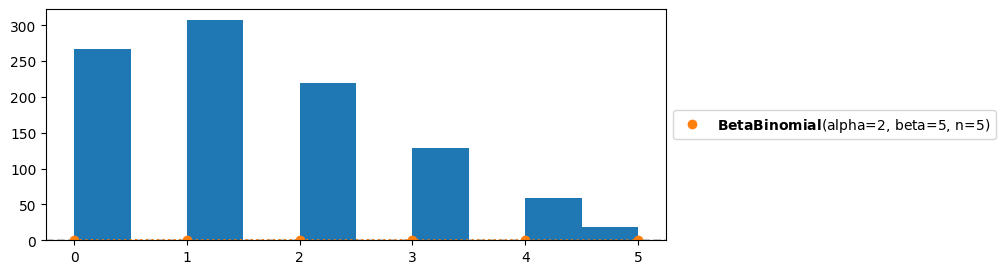

In [23]:
# Generate samples.
plt.hist(pz.BetaBinomial(alpha=2, beta=5, n=5).rvs(1000))
pz.BetaBinomial(alpha=2, beta=5, n=5).plot_pdf();

## BetaScaled

In [24]:
help(pz.BetaScaled.__init__)

Help on function __init__ in module preliz.distributions.betascaled:

__init__(self, alpha=None, beta=None, lower=0, upper=1)
    Initialize self.  See help(type(self)) for accurate signature.



In [25]:
pz.BetaScaled(alpha=2.0, beta=1.0, lower=-5, upper=5).plot_interactive(**params)

interactive(children=(FloatSlider(value=2.0, description='alpha (0, inf)', max=12.0, min=2.220446049250313e-16…

## SkewNormal

In [26]:
help(pz.SkewNormal.__init__)

Help on function __init__ in module preliz.distributions.skewnormal:

__init__(self, mu=None, sigma=None, alpha=None, tau=None)
    Initialize self.  See help(type(self)) for accurate signature.



In [27]:
# Alpha controls the skewness.
pz.SkewNormal(mu=0, sigma=1.0, alpha=1.0).plot_interactive(**params)

interactive(children=(FloatSlider(value=0.0, description='mu (-inf, inf)', max=10.0, min=-10.0, style=SliderSt…

## StudentT

In [28]:
help(pz.StudentT.__init__)

Help on function __init__ in module preliz.distributions.studentt:

__init__(self, nu=None, mu=None, sigma=None, lam=None)
    Initialize self.  See help(type(self)) for accurate signature.



In [27]:
pz.StudentT(mu=0, sigma=1, nu=3.0).plot_interactive(**params)

interactive(children=(FloatSlider(value=3.0, description='nu (0, inf)', max=13.0, min=2.220446049250313e-16, s…

## Half normal

In [29]:
help(pz.HalfNormal.__init__)

Help on function __init__ in module preliz.distributions.halfnormal:

__init__(self, sigma=None, tau=None)
    Initialize self.  See help(type(self)) for accurate signature.



In [29]:
pz.HalfNormal(sigma=1.0).plot_interactive(**params)

interactive(children=(FloatSlider(value=1.0, description='sigma (0, inf)', max=11.0, min=2.220446049250313e-16…

## Exponential

In [30]:
help(pz.Exponential.__init__)

Help on function __init__ in module preliz.distributions.exponential:

__init__(self, lam=None, beta=None)
    Initialize self.  See help(type(self)) for accurate signature.



In [31]:
pz.Exponential(beta=1.0).plot_interactive(**params)

interactive(children=(FloatSlider(value=1.0, description='beta (0, inf)', max=11.0, min=2.220446049250313e-16,…

## Gamma

In [32]:
#help(pz.Gamma)
help(pz.Gamma.__init__)

# Represents the sum of alpha exponentially distributed random variables,
# each of which has rate beta.

Help on function __init__ in module preliz.distributions.gamma:

__init__(self, alpha=None, beta=None, mu=None, sigma=None)
    Initialize self.  See help(type(self)) for accurate signature.



- Model the time until an event occurs a certain number of times, assuming that the event follows a Poisson
  process (where events occur independently at a constant average rate). 

In [31]:
pz.Gamma(alpha=1.0, beta=1.0).plot_interactive(**params)

interactive(children=(FloatSlider(value=1.0, description='alpha (0, inf)', max=11.0, min=2.220446049250313e-16…

## Poisson

- Model the number of events in a fixed interval of time, space, etc
- We assume that the events happen independently and at a constant average rate
- Assume mean equal to variance

- E.g.,
  - Call centers: model the number of customers per hour
  - Natural events: predict the number of earthquakes in a given region over a specific time
  - Traffic flow: number of cars passing through a toll booth in a day
  - Biology: count the number of mutations in a specific DNA segment over time

In [77]:
?pz.Poisson.__init__

Signature: pz.Poisson.__init__(self, mu=None)
Docstring: Initialize self.  See help(type(self)) for accurate signature.
File:      /venv/lib/python3.12/site-packages/preliz/distributions/poisson.py
Type:      function

In [32]:
pz.Poisson(mu=1.0).plot_interactive(**params)

interactive(children=(FloatSlider(value=1.0, description='mu (0, inf)', max=11.0, min=2.220446049250313e-16, s…

## NegativeBinomial

- Model the number of failures/trials to achieve a fixed number of successes in a sequence of IID Bernoulli trials
- It is a generalization of the geometric distribution, which models the number of trials needed to achieve the first success
- It models overdispersion (i.e., when mean is much smaller than variance)

- E.g.,
    - Customer service: model the number of unsuccessful customer interactions before achieving success
    - Sports: number of games a team needs to lose before winning a number of games

In [34]:
n_trials = [0, 1, 2, 3, 4, 8, 16, 32, 50, 150]
n_heads = [0, 1, 1, 1, 1, 4, 6, 9, 13, 48]
theta_real = 0.35

params = (1, 1)
x = np.linspace(0, 1, 2000)

In [79]:
#help(pm.sample)

In [36]:
import contextlib
import os
import sys


def get_posterior(alpha, beta, data, verbosity=False):
    if not verbosity:
        old_val = logging.getLogger('pymc').getEffectiveLevel()
        logging.getLogger('pymc').setLevel(logging.WARNING)
    #
    with pm.Model() as model:
        # - Prior.
        # \theta ~ Beta(\alpha=1, \beta=1)
        theta = pm.Beta("theta", alpha=alpha, beta=beta)
        # Likelihood.
        # - We pass the data using `observed` to condition the unknown to the knows (data).
        y = pm.Bernoulli('y', p=theta, observed=data)
        # Inference button.
        # - Compute 1000 samples from the posterior and store in `idata`.
        # - NUTS is a sampler that works for continuous variables.
        #
        idata = pm.sample_prior_predictive()
        idata_sample = pm.sample(1000, progressbar=False, chains=1, random_seed=123)
        idata.extend(idata_sample)
        pm.sample_posterior_predictive(idata, extend_inferencedata=True)
    if not verbosity:
        logging.getLogger('pymc').setLevel(old_val)
    return idata

In [37]:
import logging

In [38]:
def generate_data(n_heads, n_trials):
    assert n_heads <= n_trials
    data = [1] * n_heads + [0] * (n_trials - n_heads)
    return data

In [39]:
data = generate_data(5, 10)

In [40]:
idata = get_posterior(1, 1, data)

Output()

In [41]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

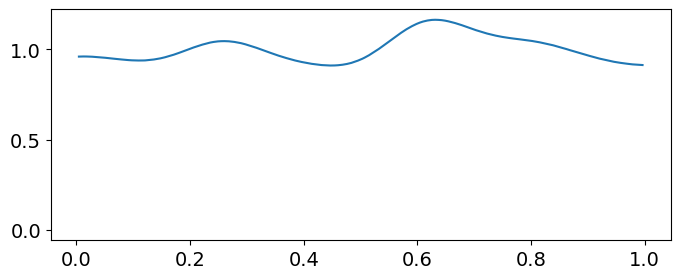

In [42]:
#az.plot_kde(idata.posterior["theta"].values);
az.plot_kde(idata.prior["theta"].values);

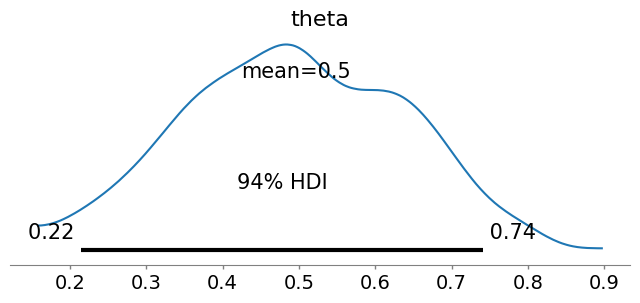

In [43]:
az.plot_posterior(idata);

In [44]:
#np.ravel(idata.posterior.theta.values)

In [45]:
sns.kdeplot(np.ravel(idata.posterior.theta.values))
#theta = pm.Beta("

DEBUG:jupyter_black:('unterminated string literal (detected at line 2)', (2, 17))


SyntaxError: unterminated string literal (detected at line 2) (2499794323.py, line 2)